In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
!pip install seaborn
import seaborn as sns

from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

You should consider upgrading via the 'C:\Users\mania\.venv\qml-winterschool\Scripts\python.exe -m pip install --upgrade pip' command.


C:\Users\mania\AppData\Local\Temp\ipykernel_17600\1852684066.py:8: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


In [2]:
SEED = 42
qasm_sim = AerSimulator()
sns.set_context('poster')
plt.style.use('seaborn-v0_8-colorblind')

# Dataset

In [35]:
# Load data into feature and target variables.
X, y = datasets.load_diabetes(return_X_y=True)

# Print number of features and samples.
print("The Number of Features is: {}".format(X.shape[1]))
print("The Number of Samples is: {}".format(X.shape[0]))

The Number of Features is: 10
The Number of Samples is: 442


In [36]:
# Reserve 25% of data for testing.
test_ratio = 0.25

# Split data into train and test *before* preprocessing to ensure no data leakage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=SEED)

# Print number of samples in each set.
print("There are {} samples in the training set".format(X_train.shape[0]))
print("There are {} samples in the test set".format(X_test.shape[0]))

There are 331 samples in the training set
There are 111 samples in the test set


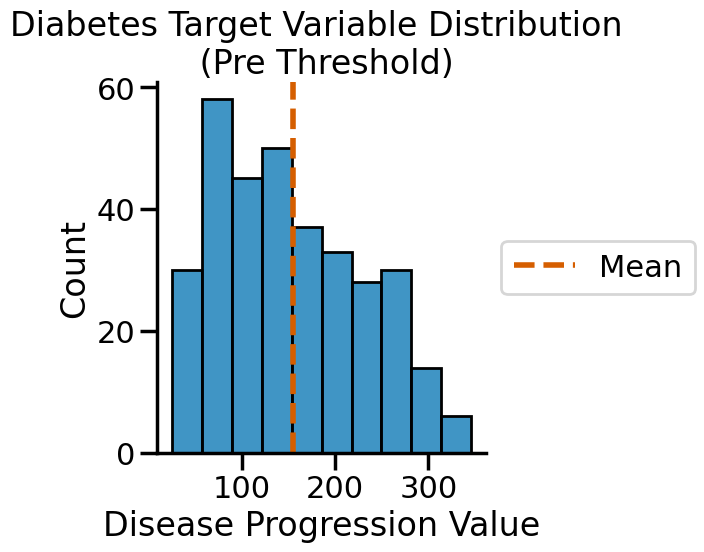

In [37]:
# Target variable statistics.

sns.displot(y_train)
plt.xlabel("Disease Progression Value")
plt.title("Diabetes Target Variable Distribution \n (Pre Threshold)")

plt.axvline(x=y_train.mean(), color=sns.palettes.color_palette('colorblind')[3], ls='--', lw=4, label="Mean")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [6]:
# Get mean disease progression value for thresholding.
y_train_mean = y_train.mean()
print("The mean disease progression value is: {}".format(y_train_mean))

# Threshold the training and test sets based on the mean value.
y_train = np.where(y_train >= y_train_mean, 1, 0)
y_test = np.where(y_test < y_train_mean, 1, 0)

The mean disease progression value is: 154.34441087613294


Text(0.5, 1.0, 'Diabetes Target Variable Distribution \n (Post Threshold)')

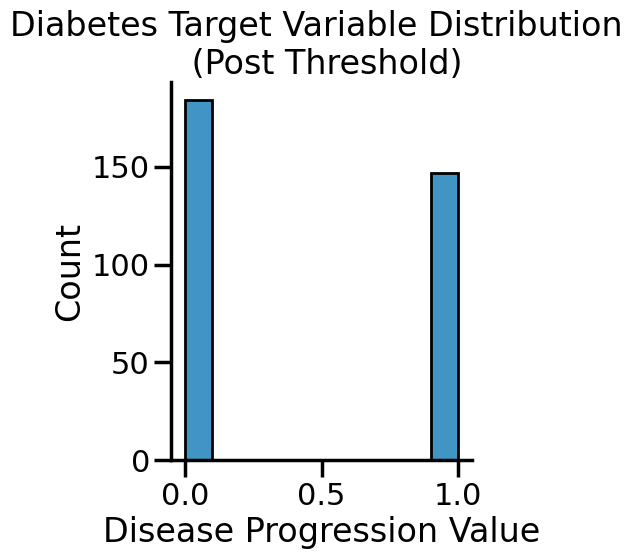

In [7]:
# Target variable statistics.

sns.displot(y_train)
plt.xlabel("Disease Progression Value")
plt.title("Diabetes Target Variable Distribution \n (Post Threshold)")

# Data embedding circuits

C:\Users\mania\.venv\qml-winterschool\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


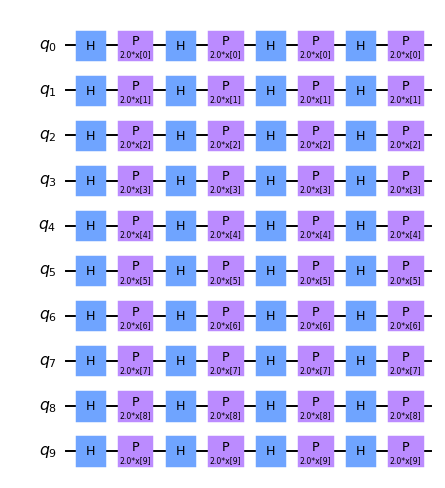

In [8]:
# Define feature map function.
def get_z_feature_map(feature_dim, feature_map_rep):
    return ZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep)

# Define number of features.
num_features = X.shape[1]

# Test feature map with n repetitions.
fmap_z = get_z_feature_map(num_features, 4)
input_params = fmap_z.parameters
fmap_z.decompose().draw('mpl', scale=0.7)

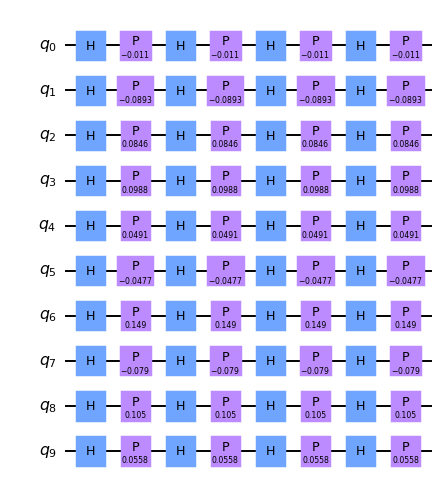

In [9]:
fmap_z.assign_parameters({k:v for (k,v) in zip(fmap_z.parameters, X_train[0])}).decompose().draw('mpl', scale=0.7)

# Anstaz

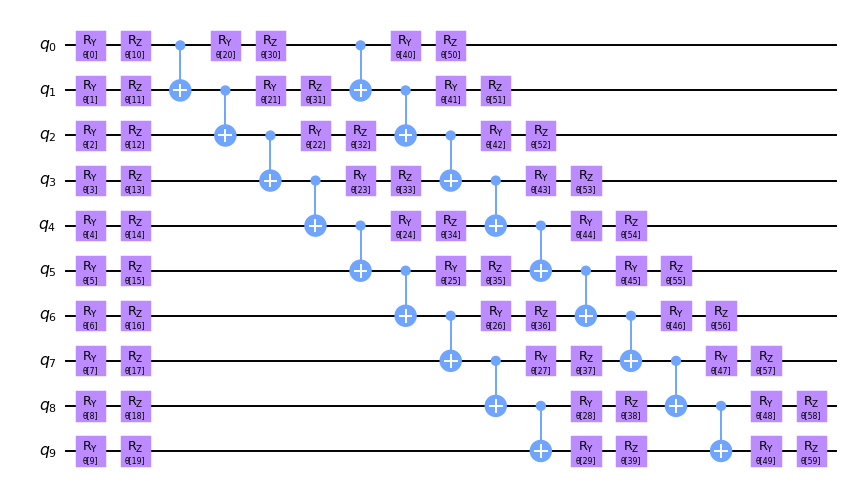

In [10]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(num_features, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz_tl.parameters
ansatz_tl.decompose().draw('mpl', scale=0.7)

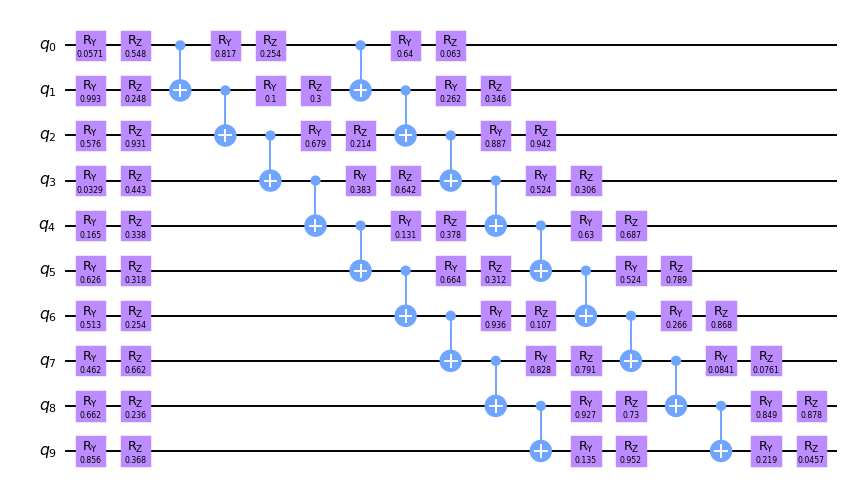

In [11]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

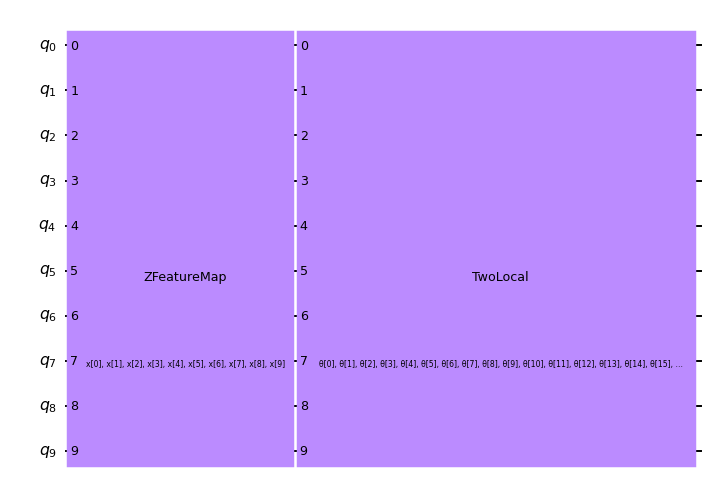

In [12]:
var_circuit = fmap_z.compose(ansatz_tl)
var_circuit.draw('mpl', scale=0.7)

# Primitives

For info, see https://docs.quantum.ibm.com/run/primitives

In [13]:
# for qiskit_ibm_runtime.Options, see https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.Options
options = {}
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

# Quantum Neural Network

## SamplerQNN

In [14]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [15]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [16]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
                         circuit=var_circuit_with_meas,
                         input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                        # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                        # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=2,
                         gradient=paramShiftSampGrad)

### Forward pass

In [17]:
# The result of the neural network on a forward pass.
output = sampler_qnn.forward(X_train, weights)
print(f"Output shape for {len(X_train)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 331 samples: (331, 2)
Output of the forward pass for first sample: [0.59863281 0.40136719]


### Backward pass

In [19]:
# The result of the neural network on a backward pass
_, weights_grad = sampler_qnn.backward(X_train, weights)
print(f"Output shape for {len(X_train)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")


Output shape for 331 samples: (331, 2, 60)
Output of the backward pass for first sample: [[-0.18212891 -0.06005859  0.04345703  0.00292969  0.00292969 -0.00292969
   0.00195312  0.0078125   0.00976562 -0.00683594  0.0625      0.07763672
  -0.00634766 -0.01806641 -0.00927734 -0.00585938 -0.00976562  0.01318359
   0.01318359  0.01074219 -0.38916016 -0.03173828 -0.00439453 -0.00878906
   0.00390625 -0.01123047  0.00341797 -0.00439453 -0.00244141 -0.00634766
   0.10009766  0.03613281  0.00634766  0.00195312 -0.01074219 -0.00146484
  -0.02148438 -0.00097656  0.01953125  0.01611328 -0.16308594  0.01318359
   0.00048828 -0.02001953 -0.00683594 -0.00048828  0.00683594  0.00488281
  -0.00048828 -0.01708984 -0.00439453 -0.00097656  0.00292969  0.01123047
  -0.00976562  0.0078125  -0.00195312  0.01855469 -0.01953125 -0.01074219]
 [ 0.18212891  0.06005859 -0.04345703 -0.00292969 -0.00292969  0.00292969
  -0.00195312 -0.0078125  -0.00976562  0.00683594 -0.0625     -0.07763672
   0.00634766  0.01806

## EstimatorQNN

In [17]:
obs_parity = Pauli('Z' * num_features)
obs_one_qubit = Pauli('I' * (num_features - 1) + 'Z')
print(f"Parity observable: {obs_parity}")
print(f"First qubit observable: {obs_one_qubit}")

Parity observable: ZZZZZZZZZZ
First qubit observable: IIIIIIIIIZ


In [18]:
paramShiftEstGrad = ParamShiftEstimatorGradient(estimator=estimator)

estimator_qnn = EstimatorQNN(estimator=estimator,
                             circuit=var_circuit,
                             observables=obs_one_qubit,
                             input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                            # (e.g. amplitude encoding) you will have to do some extra work!
                             weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                            # parameters of the embedding must be added
                             gradient=paramShiftEstGrad)

### Forward pass

In [22]:
# The result of the neural network on a forward pass.
output = estimator_qnn.forward(X_train, weights)
print(f"Output shape for {len(X_train)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 331 samples: (331, 1)
Output of the forward pass for first sample: [0.20898438]


### Backward pass

In [23]:
# The result of the neural network on a backward pass
_, weights_grad = estimator_qnn.backward(X_train, weights)
print(f"Output shape for {len(X_train)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

Output shape for 331 samples: (331, 1, 60)
Output of the backward pass for first sample: [[-0.36523438 -0.12402344  0.12011719  0.03320312  0.00097656 -0.0078125
   0.05078125 -0.00390625 -0.04199219 -0.01464844  0.0625      0.18359375
   0.         -0.00683594 -0.01367188 -0.02148438  0.0078125  -0.02246094
   0.00585938  0.         -0.79394531 -0.04785156  0.02441406 -0.02636719
  -0.01464844 -0.00683594  0.00292969 -0.00488281  0.03710938  0.02539062
   0.24023438  0.09765625 -0.01953125  0.04003906  0.03125     0.02246094
   0.01855469 -0.00488281  0.02441406 -0.03125    -0.29003906  0.00195312
   0.03710938 -0.01171875  0.015625    0.01953125 -0.02539062 -0.00097656
  -0.03027344  0.01074219 -0.0078125  -0.02050781  0.0234375   0.03613281
  -0.01367188 -0.04589844  0.00585938 -0.02050781  0.02441406  0.02636719]]


# Train a Neural Network Classifier

In [19]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

Label 1 converted to [0 1]
Label 1 converted to [0 1]


In [20]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        # print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [27]:
max_itr = 100
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

vqc = vqc.fit(X_train, y_train_1h)

Text(0.5, 1.0, 'Training loss')

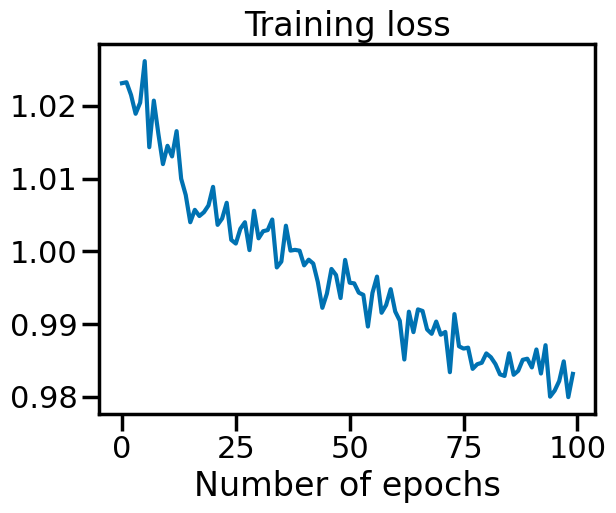

In [28]:
plt.plot(spsa_loss_recorder)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [29]:
score_train = vqc.score(X_train, y_train_1h)
score_test = vqc.score(X_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.5830815709969789
Score on the test set 0.4144144144144144


In [36]:
y_train_pred = vqc.predict(X_train)
y_test_pred = vqc.predict(X_test)

In [37]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

Text(0.5, 1.0, 'Z Feature Map Performance')

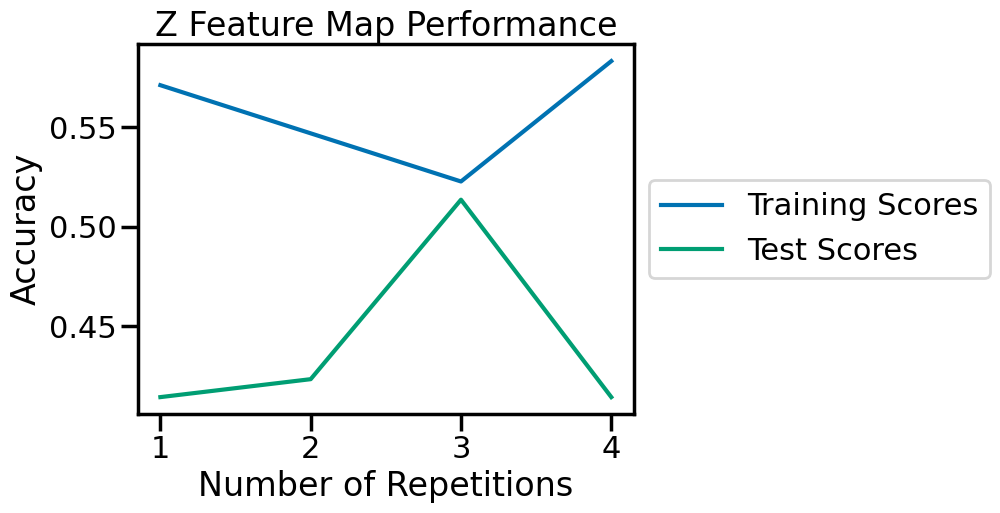

In [33]:
# Aggregated Results Statistics

train_scores = [0.570996979, 0.546827795, 0.52265861, 0.583081571]
test_Scores = [0.414414414414414, 0.423423423423423, 0.513513513513513, 0.414414414414414]
number_of_reps = [1, 2, 3, 4]

plt.plot(number_of_reps, train_scores, label='Training Scores')
plt.plot(number_of_reps, test_Scores, label='Test Scores')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Number of Repetitions")
plt.ylabel("Accuracy")
plt.title("Z Feature Map Performance")